In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2

In [2]:
# Finds largest contour within bounding box
def findROIContour(thresh, bbox):
    bbox = map(int, bbox)
    x, y, w, h = bbox
    # ROI based off bounding box coordinates
    thresh_roi = thresh[y:y+h, x:x+w]
    # Mask of black pixels so only ROI is searched for contour
    mask = np.zeros((thresh.shape[0], thresh.shape[1]), np.uint8)
    mask[y:y+h, x:x+w] = thresh_roi
    
    # Taken from: https://stackoverflow.com/questions/54615166/find-the-biggest-contour-opencv-python-getting-errors
    contours = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    contour_areas = [(cv2.contourArea(contour), contour) for contour in contours[0]]
    # If no contour, return None
    #print(contour_areas)
    if contour_areas is None or len(contour_areas)==0:
        final_c = [None, None]
    else:
        final_c = max(contour_areas, key=lambda x: x[0]) # Find largest contour in box
    return final_c[1]

# Find Centre coordinates of contour
def getContourMoment(contour):
    m = cv2.moments(contour)
    # Find Contour centre 
    x = m['m10'] / m['m00']
    y = m['m01'] / m['m00']
    return int(x), int(y) 

# Finds the full contour based on bounding box ROI
def findFullContour(thresh, centre):
    x, y = centre
    # Find all contours in image
    contours = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    # Return contour that centre belongs to
    for c in contours[0]:
        dist = cv2.pointPolygonTest(c, (x,y), False)
        if dist == 1.0:
            final_contour = c
            #print('Contour Found')
            #if cv2.contourArea(c) > size * 1.5:
            #    pass
            break
        else:
            final_contour = findROIContour(thresh, (x-10, y-10, 20, 20))
    #print(final_contour)
    return final_contour

# Fits a bounding box tightly around the contour
def getFittedBox(contour):
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    return rect, box

# Converts a fitted bounding box to a straight one with no rotation 
def rotatedBoxConverter(box):
    box_t = np.array(box).T
    x, y = min(box_t[0]), min(box_t[1])
    w, h = max(box_t[0]) - x, max(box_t[1]) - y
    return x, y, w, h

# Calculate avg area of box
def avgArea(box, total, count):
    x, y, w, h = box
    total += w * h
    avg = total / count
    return total, avg




### Remove Duplicates

In [3]:
waggle_df = pd.read_pickle('WaggleDetections-Bees10.pkl')
#waggle_df.drop(['index'], axis=1, inplace=True)
#waggle_df.reset_index(inplace=True)
# Sort by cluster and then frame so the dataset is ordered in blocks of clusters
waggle_df = waggle_df.sort_values(by=['Cluster', 'frame']).reset_index().drop(['index'], axis=1).reset_index()

In [4]:
waggle_df[waggle_df['Cluster']==2]

,index,x,y,frame,size,contour,Cluster
81,81,1087,569,60,213.5,"[[[1074, 561]], [[1074, 562]], [[1074, 563]], ...",2
82,82,1089,559,61,294.0,"[[[1091, 548]], [[1091, 549]], [[1091, 550]], ...",2
83,83,1064,562,63,207.5,"[[[1056, 551]], [[1057, 552]], [[1057, 553]], ...",2
84,84,1080,544,63,197.0,"[[[1069, 533]], [[1070, 534]], [[1070, 535]], ...",2
85,85,1075,569,67,256.0,"[[[1061, 537]], [[1061, 538]], [[1061, 539]], ...",2
86,86,1072,547,71,283.5,"[[[1065, 527]], [[1064, 528]], [[1063, 528]], ...",2
87,87,1079,558,77,289.5,"[[[1086, 537]], [[1085, 538]], [[1084, 539]], ...",2
88,88,1090,569,79,232.5,"[[[1110, 552]], [[1109, 553]], [[1108, 554]], ...",2
89,89,1075,539,79,267.0,"[[[1042, 521]], [[1042, 522]], [[1043, 523]], ...",2
90,90,1101,555,80,232.5,"[[[1093, 537]], [[1092, 538]], [[1091, 538]], ...",2


In [5]:
# All rows duplicated on frame and cluster
dup = waggle_df[waggle_df.duplicated(subset=['frame', 'Cluster'], keep=False)] # Returns all rows that match on frame and cluster
dup

# All non duplicated rows
non_dup = waggle_df[~waggle_df.duplicated(subset=['frame', 'Cluster'], keep=False)] # Returns all rows that match on frame and cluster

In [6]:
dup

,index,x,y,frame,size,contour,Cluster
1,1,1076,261,2,405.0,"[[[1070, 233]], [[1069, 234]], [[1069, 235]], ...",0
2,2,1041,250,2,443.0,"[[[1028, 233]], [[1027, 234]], [[1026, 235]], ...",0
8,8,1037,247,9,358.5,"[[[1052, 226]], [[1051, 227]], [[1050, 227]], ...",0
9,9,1075,243,9,689.5,"[[[1058, 210]], [[1057, 211]], [[1056, 212]], ...",0
10,10,1075,254,10,627.0,"[[[1074, 231]], [[1073, 232]], [[1073, 233]], ...",0
...,...,...,...,...,...,...,...
14439,14439,1205,483,13598,274.0,"[[[1214, 467]], [[1213, 468]], [[1212, 468]], ...",511
14443,14443,1227,500,13603,328.5,"[[[1218, 473]], [[1219, 474]], [[1220, 475]], ...",511
14444,14444,1199,492,13603,213.5,"[[[1196, 467]], [[1195, 468]], [[1194, 469]], ...",511
14448,14448,1227,513,13611,298.0,"[[[1220, 486]], [[1221, 486]], [[1222, 487]], ...",511


In [7]:
a = dup.index.values
b = dup.index.values - 1 # Rows before duplicate
c = dup.index.values + 1 # Rows after duplicate

# Concatenate removing duplicate indices
idx = np.unique(np.concatenate((a, b, c)))

df = waggle_df[waggle_df.index.isin(idx)]
df['Cluster'].value_counts()

302    116
503     89
511     85
461     78
181     77
      ... 
348      1
428      1
418      1
372      1
206      1
Name: Cluster, Length: 392, dtype: int64

In [8]:
df[df['Cluster']==2]

,index,x,y,frame,size,contour,Cluster
82,82,1089,559,61,294.0,"[[[1091, 548]], [[1091, 549]], [[1091, 550]], ...",2
83,83,1064,562,63,207.5,"[[[1056, 551]], [[1057, 552]], [[1057, 553]], ...",2
84,84,1080,544,63,197.0,"[[[1069, 533]], [[1070, 534]], [[1070, 535]], ...",2
85,85,1075,569,67,256.0,"[[[1061, 537]], [[1061, 538]], [[1061, 539]], ...",2
87,87,1079,558,77,289.5,"[[[1086, 537]], [[1085, 538]], [[1084, 539]], ...",2
88,88,1090,569,79,232.5,"[[[1110, 552]], [[1109, 553]], [[1108, 554]], ...",2
89,89,1075,539,79,267.0,"[[[1042, 521]], [[1042, 522]], [[1043, 523]], ...",2
90,90,1101,555,80,232.5,"[[[1093, 537]], [[1092, 538]], [[1091, 538]], ...",2


In [9]:
pts = df[['index', 'x','y','frame']].values

#pts = pts[np.argsort(pts[:, -1], axis = 0)]    # to sort about last column if not sorted
# Returns indices of duplicates
same_pts = [np.argwhere(i[0] == pts[:, -1]) for i in np.array(np.unique(pts[:, -1], return_counts=True)).T if i[1]>=2]
remove_row = []
for i in same_pts:
    dist = []
    pre = min(i)-1
    post = max(i)+1
    for j in i:
        # Euclidean distance from duplicate points and the point in the frame before and after 
        dist_pre = np.sqrt((pts[pre, 1]-pts[j, 1])**2 + (pts[pre, 2]-pts[j, 2])**2)
        dist_post = np.sqrt((pts[post, 1]-pts[j, 1])**2 + (pts[post, 2]-pts[j, 2])**2)
        dist.append(dist_pre + dist_post)
    remove_row.append(i[np.argmax(dist)][0])
# Returns pts with furthest duplicates removed
final_pts = np.delete(pts, remove_row, axis = 0)

In [10]:
# Concatenate final_pts index with non_duplicate index, removing unique values
final_idx = np.unique(np.concatenate((non_dup.index.values, final_pts[:, 0])))

In [11]:
df = waggle_df[waggle_df['index'].isin(final_idx)]

In [12]:
df['Cluster'].value_counts()
#df[df['Cluster']==229]

302    97
181    82
511    79
296    77
461    71
       ..
140     9
125     9
399     9
250     9
477     8
Name: Cluster, Length: 512, dtype: int64

In [13]:
df[df['Cluster']==2]

,index,x,y,frame,size,contour,Cluster
81,81,1087,569,60,213.5,"[[[1074, 561]], [[1074, 562]], [[1074, 563]], ...",2
82,82,1089,559,61,294.0,"[[[1091, 548]], [[1091, 549]], [[1091, 550]], ...",2
83,83,1064,562,63,207.5,"[[[1056, 551]], [[1057, 552]], [[1057, 553]], ...",2
85,85,1075,569,67,256.0,"[[[1061, 537]], [[1061, 538]], [[1061, 539]], ...",2
86,86,1072,547,71,283.5,"[[[1065, 527]], [[1064, 528]], [[1063, 528]], ...",2
87,87,1079,558,77,289.5,"[[[1086, 537]], [[1085, 538]], [[1084, 539]], ...",2
88,88,1090,569,79,232.5,"[[[1110, 552]], [[1109, 553]], [[1108, 554]], ...",2
90,90,1101,555,80,232.5,"[[[1093, 537]], [[1092, 538]], [[1091, 538]], ...",2
91,91,1078,540,83,582.5,"[[[1057, 505]], [[1056, 506]], [[1055, 506]], ...",2
92,92,1079,569,86,203.0,"[[[1073, 562]], [[1072, 563]], [[1071, 563]], ...",2


### Fill Missing

In [166]:
# Prevent tracking update failures
def anchorBox(box, prev_box, avg):
    global counter
    x0, y0, w0, h0 = prev_box
    x, y, w, h = box
    
    # If bounding box is too far from previous box
    #if abs(x - x0) > w0/2 and abs(y - y0) > h0/2:
    if abs(x - x0) > w0/3 or abs(y - y0) > h0/3: # CHANGED FOR TESTING ON BEES10 2
        print('Box Lost')
        success = False
    # If bounding box is too large
    elif abs(w * h) > (avg * 2):
        print('Box Lost (Expanded)')
        print(str(counter))
        success = 'Expanded'
    # If bounding box is too small
    elif abs(w * h) < (avg / 1.5):
        print('Box Lost (Shrunk)')
        print(str(counter))
        success = 'Shrunk'
    # prev_box only updated if box found
    else:
        print('Box Found')
        prev_box = box 
        success = True

    return success, prev_box

def expandBox(img, bbox):
    contour = None
    x, y, w, h = bbox
    x -= 10
    w += 20
    y -= 10
    h += 20
    bbox = (x, y, w, h)
    print(bbox)
    contour = findROIContour(img, bbox)
    return bbox, contour

# Find which way object is facing by the direction in which bounding box moves, to be coupled with angle of bounding rect
def moveDirection(prev_bbox, bbox):
    x, y, w, h = bbox
    x0, y0, w0, h0 = prev_bbox
    
    xd = x - x0
    # if xd is negative, moved west, if xd is positive, moved east
    yd = y - y0
    # if yd is negative, moved north, if yd is positive, moved south
    movement = (xd, yd)
    return movement

def erodeAroundROI(frame, bbox):
    x, y, w, h = bbox
    save = frame[y:y+h, x:x+w]
    kerenl = np.ones(3,3, np.uint8)
    frame = cv2.erode(frame, kernel, iterations = 3)

def createMask(img):
    mask = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)
    mask.fill(255)
    return mask

In [15]:
final_df = pd.DataFrame(columns=['x', 'y', 'frame', 'bbox', 'size', 'angle', 'cluster']) # maybe add direction change?

,index,x,y,frame,size,contour,Cluster
336,336,839,481,200,259.0,"[[[853, 458]], [[852, 459]], [[853, 458]], [[8...",12
337,337,847,493,221,216.5,"[[[826, 477]], [[825, 478]], [[824, 479]], [[8...",12
338,338,828,485,222,344.5,"[[[819, 472]], [[819, 473]], [[819, 474]], [[8...",12
339,339,834,488,223,508.0,"[[[819, 472]], [[819, 473]], [[819, 474]], [[8...",12
340,340,825,482,224,336.5,"[[[816, 465]], [[815, 466]], [[814, 467]], [[8...",12
341,341,825,484,225,484.0,"[[[816, 465]], [[815, 466]], [[814, 467]], [[8...",12
342,342,823,483,226,342.5,"[[[818, 467]], [[818, 468]], [[817, 469]], [[8...",12
343,343,824,483,227,190.5,"[[[818, 467]], [[818, 468]], [[817, 469]], [[8...",12
344,344,822,481,231,220.5,"[[[821, 467]], [[820, 468]], [[820, 469]], [[8...",12
345,345,823,478,234,303.5,"[[[824, 466]], [[823, 467]], [[822, 468]], [[8...",12


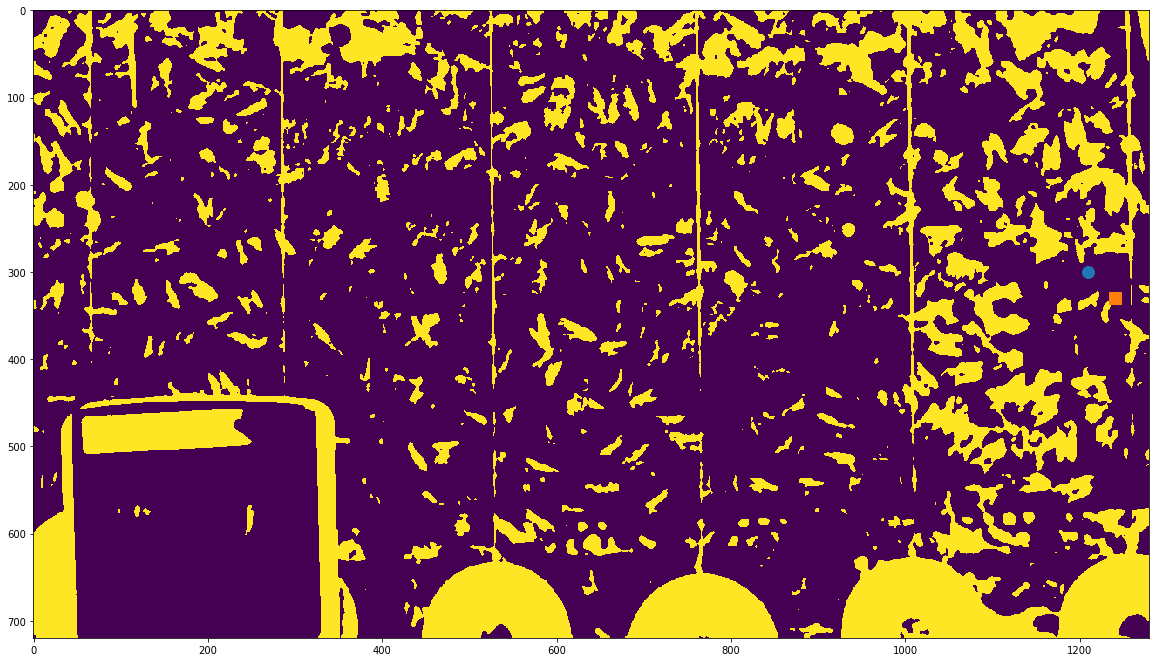

In [179]:
clust = df[df['Cluster']==12] # 1, 6, 35, 72 (didn't work, also not a waggle), 75, 222, 245 (also not a waggle)
# 6 doesn't work. Loses it when it crosses the white lime
# 1 fixed by changing the 'contour is none' code to thresh within the roi
# 100 is an example where the last two frames are wrong
# 0 has some problems at end 
clust
cap = cv2.VideoCapture('../Bees10.mov')
cap.set(1, 233)
_, frame = cap.read()
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]

plt.figure(figsize=(20,20))
plt.imshow(thresh)
plt.plot(1225-15, 315-15, marker='o', markersize=12)
plt.plot(1225+15, 315+15, marker='s', markersize=12)
clust

[[[853 471]]

 [[853 472]]

 [[853 473]]

 [[853 474]]

 [[852 475]]

 [[851 475]]

 [[850 474]]

 [[849 474]]

 [[848 475]]

 [[847 475]]

 [[846 475]]

 [[845 475]]

 [[844 476]]

 [[843 476]]

 [[842 477]]

 [[841 478]]

 [[840 479]]

 [[839 479]]

 [[838 479]]

 [[837 478]]

 [[837 477]]

 [[836 476]]

 [[835 476]]

 [[835 477]]

 [[835 478]]

 [[835 479]]

 [[835 480]]

 [[835 481]]

 [[834 482]]

 [[834 483]]

 [[835 483]]

 [[836 483]]

 [[837 482]]

 [[837 481]]

 [[838 480]]

 [[839 480]]

 [[840 480]]

 [[841 481]]

 [[842 482]]

 [[842 483]]

 [[842 484]]

 [[842 485]]

 [[841 486]]

 [[841 487]]

 [[842 487]]

 [[843 486]]

 [[844 486]]

 [[845 485]]

 [[846 484]]

 [[847 483]]

 [[848 482]]

 [[849 481]]

 [[850 481]]

 [[851 480]]

 [[851 479]]

 [[852 478]]

 [[852 477]]

 [[852 476]]

 [[852 475]]

 [[853 474]]

 [[853 473]]

 [[853 472]]]
1015
[[[ 87  97 101]
  [ 84  94  98]
  [ 80  90  94]
  ...
  [214 209 221]
  [216 208 221]
  [215 207 220]]

 [[ 85  95  99]
  [ 82 

-1

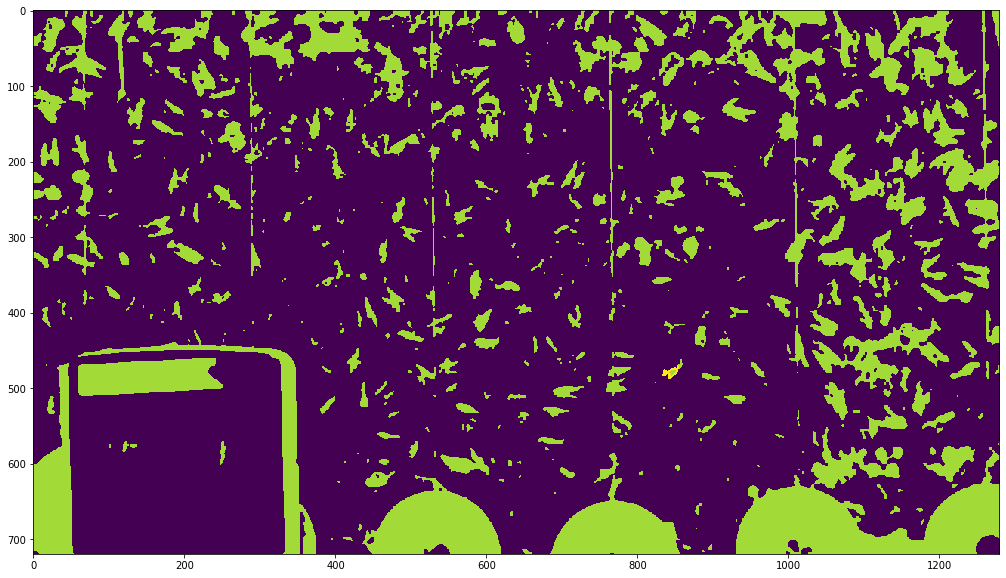

In [180]:
start = clust.iloc[0, :]['frame']
end = clust.iloc[-1, :]['frame']
cluster = clust.iloc[0, :]['Cluster']
# Get range of frames where waggle occurs
rang = np.arange(start, end, 1)
missing = list(set(rang)-set(clust.frame.values)) # Frames where waggle missing from df

counter = start
cap = cv2.VideoCapture('../Bees10.mov')
cap.set(1, start)
ret, frame = cap.read()
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Preprocessing
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
thresh_min, thresh_max = 120, 220
thresh = cv2.threshold(gray, thresh_min, thresh_max, cv2.THRESH_BINARY)[1]
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
opening = cv2.erode(opening, kernel, iterations=1)

# Find contour bounding box
x, y = clust.iloc[0, :]['x'], clust.iloc[0]['y']
bbox = x-15, y-15, 30, 30

contour = findROIContour(opening, bbox)
print(contour)
if contour is None:
    print('Contour None')
    contour = findROIContour(thresh, bbox)
    opening = thresh # For findFullContour
plt.figure(figsize=(20,10))
cv2.drawContours(opening, contour, -1, (255,0,0), 2, 1)
plt.imshow(opening)
centre = getContourMoment(contour)
contour = findFullContour(opening, centre)
if cv2.contourArea(contour) > clust['size'].max():
    contour = findROIContour(opening, bbox)
    print(contour)
rect, box = getFittedBox(contour)
bbox = rotatedBoxConverter(box)
prev_bbox = bbox
found = True
avg = bbox[2]*bbox[3]
total = avg
print(avg)

# Create tracker 
print(frame)
tracker = cv2.TrackerCSRT_create()
tracker.init(frame, bbox)

rois = []

while counter < end:
    counter += 1 
    print(counter)
    ret, frame = cap.read()
    
    # Preprocessing
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (15,15), 1)
    thresh = cv2.threshold(gray, thresh_min, thresh_max, cv2.THRESH_BINARY)[1]
    kernel = np.ones((2,2),np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    opening = cv2.erode(opening, kernel, iterations=1)
    
    if counter not in missing:
        print('In DF')
        waggle = clust[clust['frame']==counter].reset_index()
        x, y = waggle.loc[0, 'x'], waggle.loc[0, 'y']
        bbox = x-15, y-15, 30, 30
        print(prev_bbox, bbox)
        # If found is false, either false positive in detection DF or false positive in previous frame
        found, prev_bbox = anchorBox(bbox, prev_bbox, avg)
        
    # If frame not in df, use tracker to fill in the missing
    if counter in missing: #or found is False:
        if counter in missing:
            print('Missing')
#         else:
#             print('DF False positive')
        bbox = prev_bbox[0] - 5, prev_bbox[1] - 5, prev_bbox[2] + 10, prev_bbox[3] + 10
        print(prev_bbox, bbox)
    
    # If bbox goes out of frame, end tracking 
    if bbox[0] < 0 or bbox[0] > width or bbox[1] < 0 or bbox[1] > height:
        print('Object out of bounds')
        final_df.loc[len(final_df)] = 0
        break        
    
    
    # FIX needed here to prevent jumping
    """ Current idea: Degrade around the outside + 10 of prev_bbox, then use prev_bbox + 5 for Contour detection.
        Found needs to be checked for 'missing' too."""

    # Erode outside bounding box, no operation inside the bounding box
    save = opening[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
    opening = cv2.erode(opening, kernel, iterations=3)
    opening[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]] = save

    
    # Find contour from bbox. If None, lower threshold inside the bounding box
    contour = findROIContour(opening, bbox)
    if contour is None:
        print('Contour None')
        contour = findROIContour(thresh, bbox)
        opening = thresh # For findFullContour
    # If contour still None, dilate
    low = thresh_min
    while contour is None or cv2.contourArea(contour) <= 80: # or too small
        print('Contour still none')
        low -= 5
        thresh = cv2.threshold(gray, low, thresh_max, cv2.THRESH_BINARY)[1]
        opening[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]] = thresh[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
        contour = findROIContour(opening, bbox)
        #opening = dilate # For findFullContour

    roi_contour = contour # Save for use in findFullContour failure
    # Readjust centre and find full contour outside ROI
    centre = getContourMoment(contour)
    contour = findFullContour(opening, centre)
    # If contour too large, erode image, then use ROI
    while cv2.contourArea(contour) > clust['size'].max():
        opening = cv2.erode(opening, kernel, iterations = 1)
        bbox = centre[0]-15, centre[1]-15, 30, 30
        contour = findROIContour(opening, bbox)
        if contour is None:
            print('Using previous ROI contour')
            contour = roi_contour
            break
    rect, box = getFittedBox(contour)
    bbox = rotatedBoxConverter(box)
    
    found, prev_bbox = anchorBox(bbox, prev_bbox, avg)
    
    if found is not True:
        print('Found is False')
        contour = roi_contour
        centre = getContourMoment(contour)
        bbox = centre[0]-15, centre[1]-15, 30, 30
        contour = findROIContour(opening, bbox)
        rect, box = getFittedBox(contour)
        bbox = rotatedBoxConverter(box)
    
    if bbox[2]*bbox[3] > avg*1.5:
        print('Too Large')
        # Re-centre ROI to contour, and get bbox on cropped contour
        x, y = centre 
        bbox = x-15, y-15, 30, 30
        contour = findROIContour(opening, bbox)
        rect, box = getFittedBox(contour)
        print(rect[-1])
        bbox = rotatedBoxConverter(box)
    
    angle = rect[-1]
    size = cv2.contourArea(contour)
    
#     # If next frame is missing data, initialise tracker on bounding box
#     if counter not in missing and counter + 1 in missing:
#         print('c')
#         # find contour
#         tracker = cv2.TrackerCSRT_create()
#         tracker.init(frame, bbox)
        
    print(bbox)
    # VISUALS    
    if ret:
    # Tracking success
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv2.rectangle(frame, p1, p2, (255, 0, 0), 2, 1)
        cv2.rectangle(opening, p1, p2, (255, 0, 0), 2, 1)
    else:
        cv2.putText(frame, "Tracking failure detected", (100, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
    cv2.imshow("Tracking", frame)
    cv2.imshow("Threshold", opening)
    cv2.waitKey(100)
    if found is not True:
        if cv2.waitKey(0) & 0xFF == ord('c'):
            pass
    
    final_df.loc[len(final_df)] = [centre[0], centre[1], counter, bbox, size, angle, cluster]
    
    movement = moveDirection(prev_bbox, bbox) # Track direction of box movement
    prev_bbox = bbox
    total, avg = avgArea(bbox, total, (counter-start)) # Track avg size of bounding box

    
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

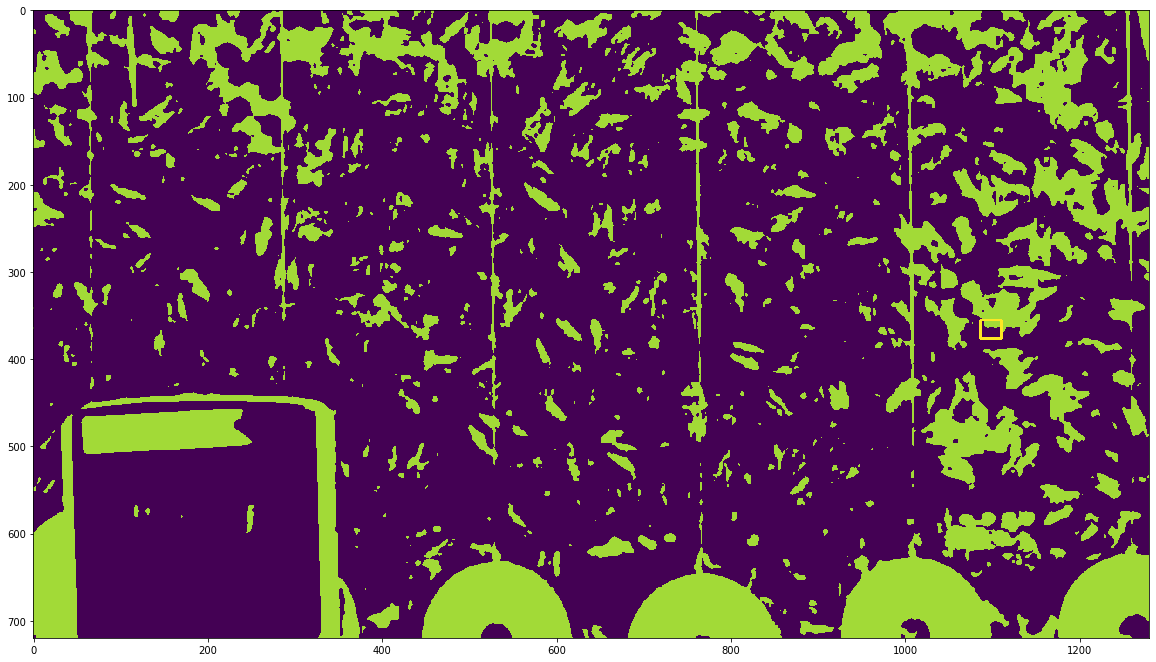

In [163]:
bbox
cap = cv2.VideoCapture('../Bees10.mov')
cap.set(1, 6)
ret, frame = cap.read()

# Preprocessing
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
opening = cv2.erode(opening, kernel, iterations=1)
dilate = cv2.dilate(opening, kernel, iterations=5)
dilate = cv2.threshold(gray, 100, 220, cv2.THRESH_BINARY)[1]
opening[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]] = dilate[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]


p1 = (int(bbox[0]), int(bbox[1]))
p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
cv2.rectangle(thresh, p1, p2, (255, 0, 0), 2, 1)
plt.figure(figsize=(20,20))
plt.imshow(thresh)

In [145]:
dilate[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]

array([[220, 220, 220, ..., 220, 220, 220],
       [220, 220, 220, ..., 220, 220, 220],
       [220, 220, 220, ..., 220, 220, 220],
       ...,
       [  0,   0,   0, ..., 220, 220, 220],
       [  0,   0,   0, ..., 220, 220, 220],
       [  0,   0,   0, ..., 220, 220, 220]], dtype=uint8)

In [44]:
21
In DF
(1061, 219, 28, 29) (1035, 222, 30, 30)
Box Lost
Contour still none
(1055, 233)
Box Lost
Found is False
(1046, 218, 23, 29)
22
Missing
(1046, 218, 23, 29) (1041, 213, 33, 39)
(1061, 226)
Box Found
(1046, 211, 29, 29)
23
In DF
(1046, 211, 29, 29) (1027, 208, 30, 30)
Box Lost
(1042, 218)
Box Lost
Found is False
(1026, 205, 33, 25)

SyntaxError: invalid syntax (<ipython-input-44-5f4ba6dc9dca>, line 1)

In [153]:
clust[clust['frame']==21]
# bbox = 1184, 313, 40, 25
# prev_bbox = bbox
# bbox = prev_bbox[0] - 5, prev_bbox[1] - 5, prev_bbox[2] + 10, prev_bbox[3] + 10
bbox = 1050-15, 237-15, 30, 30
bbox = 1061, 219, 28, 29

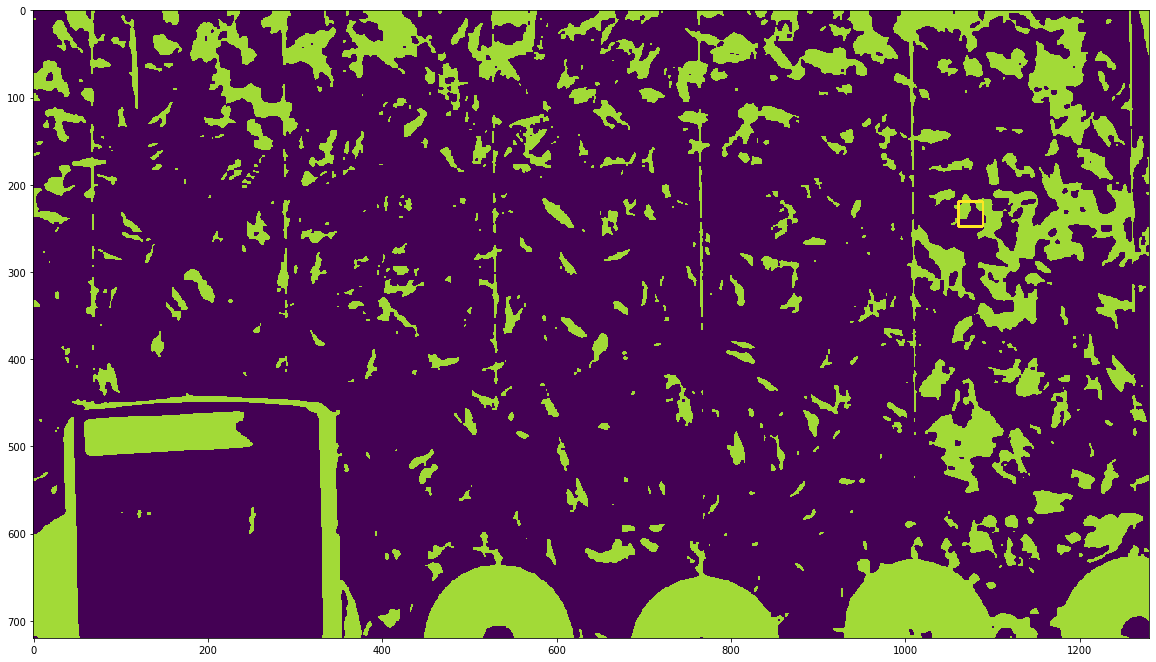

In [154]:
cap = cv2.VideoCapture('../Bees10.mov')
cap.set(1, 21)
ret, frame = cap.read()

# Preprocessing
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
opening = cv2.erode(opening, kernel, iterations=1)

p1 = (int(bbox[0]), int(bbox[1]))
p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
cv2.rectangle(opening, p1, p2, (255, 0, 0), 2, 1)
plt.figure(figsize=(20,20))
plt.imshow(opening)



In [88]:
final_df[final_df['cluster']==72]

,x,y,frame,bbox,size,angle,cluster
989,1188,303,3050,"[[1202, 317], [1173, 317], [1173, 288], [1202,...",841.0,-90.000000,72
990,1171,304,3051,"[[1158, 315], [1155, 289], [1173, 287], [1176,...",209.0,-6.340192,72
991,1159,283,3052,"[[1171, 297], [1144, 297], [1144, 268], [1171,...",361.0,-90.000000,72
992,1155,272,3053,"[[1169, 286], [1140, 286], [1140, 257], [1169,...",483.0,-90.000000,72
993,1184,315,3054,"[[1191, 320], [1179, 320], [1179, 311], [1191,...",86.5,-90.000000,72
...,...,...,...,...,...,...,...
1071,1239,313,3132,"[[1251, 327], [1234, 324], [1237, 300], [1254,...",284.5,-82.405357,72
1072,1244,302,3133,"[[1247, 314], [1232, 295], [1239, 289], [1255,...",123.5,-38.157227,72
1073,1241,287,3134,"[[1250, 296], [1231, 296], [1231, 277], [1250,...",234.0,-90.000000,72
1074,1240,276,3135,"[[1254, 290], [1225, 290], [1225, 261], [1254,...",691.5,-90.000000,72


In [ ]:
from math import cos, sin
cols = (len(final_df['bbox']) // 10) + 1
plt.figure(figsize=(40, 20))

for i in range(0, len(final_df['bbox'])):
    x = [final_df.loc[i, 'bbox'][0][0], final_df.loc[i, 'bbox'][1][0]]
    y = [final_df.loc[i, 'bbox'][0][1], final_df.loc[i, 'bbox'][1][1]]
    
    angle = final_df.loc[i, 'angle']
    x, y = final_df.loc[i, 'bbox'][0]
    x1, y1 = x + 50 * cos(angle), y + 50 * sin(angle)


    # Setting the values for all axes.
    plt.subplot(cols, 10, i+1)
    plt.plot((x, x1), (y, y1), linewidth=5)
    #plt.xlim(1150, 1250)
    #plt.ylim(250, 400)
    

#for box in final_df['bbox']

The above is not the perfect way of displaying angles, as it does not show the intricacies of the angles throughout the waggle run. However, something like this where it shows the gradient as either positive or negative allows us to see the frequency of the bees waggle, demonstrating the intensity of the waggle run.

~28 direction changes over 52 frames

25 FPS, = ~13.5 waggles per second 

This is in line with research that the bee waggles at 13-15Hz https://www.beeculture.com/a-closer-look-waggle-dances/#:~:text=2013

In [18]:
cap = cv2.VideoCapture('Bees10.mov')
fps = cap.get(cv2.CAP_PROP_FPS)
fps

25.0

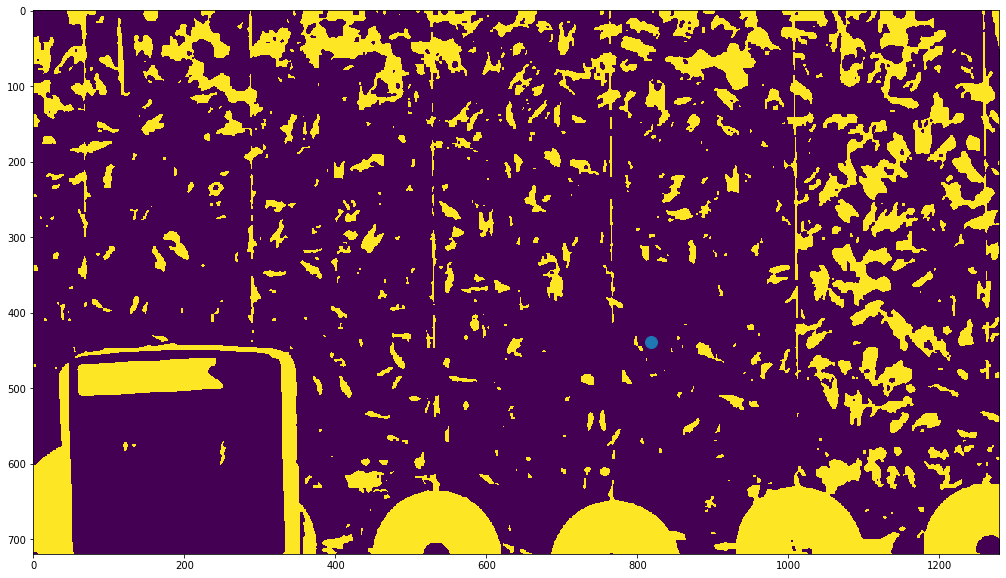

In [19]:
cap.set(1, 71)
ret, frame = cap.read()

# Preprocessing
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
#thresh = cv2.threshold(gray, 130, 220, cv2.THRESH_BINARY)[1]
thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
opening = cv2.erode(opening, kernel, iterations=1)
#opening = cv2.dilate(thresh, kernel, iterations=2)


plt.figure(figsize=(20,10))
plt.imshow(opening)
plt.plot(818, 439, marker='o', markersize=12)

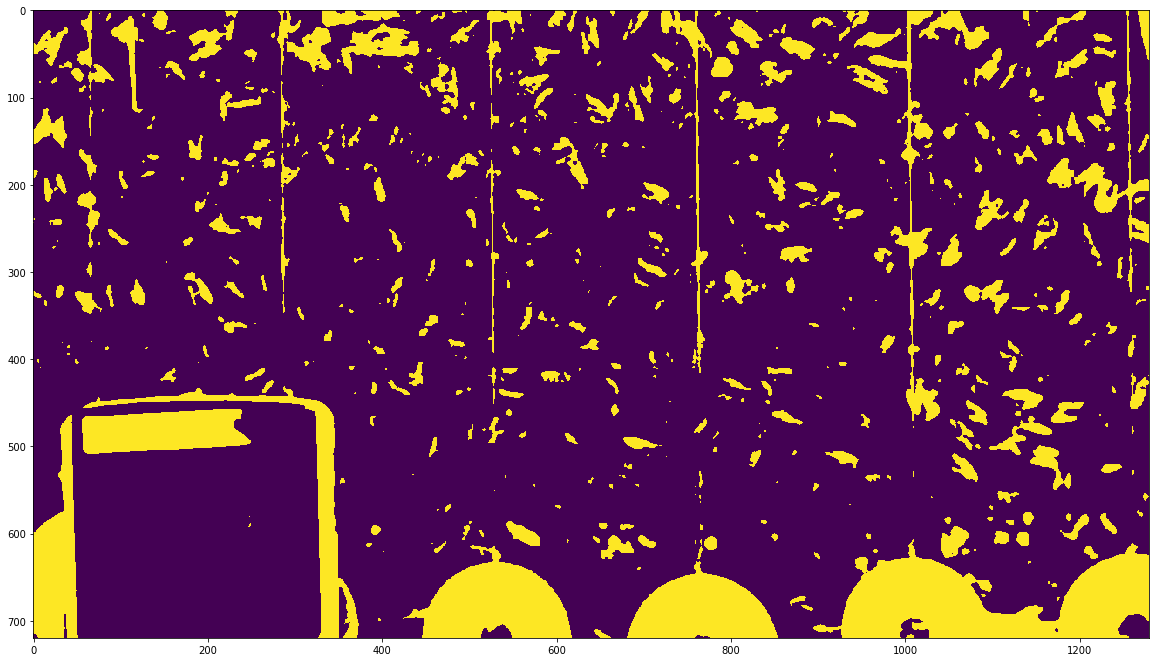

In [23]:
j = 130
# Preprocessing
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
#thresh = cv2.threshold(gray, 130, 220, cv2.THRESH_BINARY)[1]
thresh = cv2.threshold(gray, j, 220, cv2.THRESH_BINARY)[1]
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
opening = cv2.erode(opening, kernel, iterations=1)
#opening = cv2.dilate(thresh, kernel, iterations=2)
plt.figure(figsize=(20,20))
plt.imshow(thresh)

(1016, 362, 30, 30)

In [87]:
waggle_df[waggle_df['Cluster'] == 2]

,index,x,y,frame,size,contour,Cluster
81,81,1087,569,60,213.5,"[[[1074, 561]], [[1074, 562]], [[1074, 563]], ...",2
82,82,1089,559,61,294.0,"[[[1091, 548]], [[1091, 549]], [[1091, 550]], ...",2
83,83,1064,562,63,207.5,"[[[1056, 551]], [[1057, 552]], [[1057, 553]], ...",2
84,84,1080,544,63,197.0,"[[[1069, 533]], [[1070, 534]], [[1070, 535]], ...",2
85,85,1075,569,67,256.0,"[[[1061, 537]], [[1061, 538]], [[1061, 539]], ...",2
86,86,1072,547,71,283.5,"[[[1065, 527]], [[1064, 528]], [[1063, 528]], ...",2
87,87,1079,558,77,289.5,"[[[1086, 537]], [[1085, 538]], [[1084, 539]], ...",2
88,88,1090,569,79,232.5,"[[[1110, 552]], [[1109, 553]], [[1108, 554]], ...",2
89,89,1075,539,79,267.0,"[[[1042, 521]], [[1042, 522]], [[1043, 523]], ...",2
90,90,1101,555,80,232.5,"[[[1093, 537]], [[1092, 538]], [[1091, 538]], ...",2


In [133]:
final_df.loc[0:63]

,x,y,frame,bbox,size,angle,cluster
0,1041,124,111,"[[1037, 138], [1032, 117], [1045, 114], [1051,...",214.5,-14.036244,6
1,1041,122,112,"[[1045, 137], [1023, 107], [1035, 98], [1056, ...",209.0,-35.837650,6
2,1032,113,113,"[[1039, 131], [1014, 100], [1024, 91], [1050, ...",238.0,-39.472462,6
3,1013,98,114,"[[1013, 101], [1010, 98], [1012, 95], [1016, 99]]",15.0,-45.000000,6
4,1011,96,115,"[[1002, 111], [997, 80], [1018, 76], [1023, 107]]",329.5,-10.784298,6
...,...,...,...,...,...,...,...
59,1053,27,170,"[[1067, 41], [1038, 41], [1038, 12], [1067, 12]]",616.0,-90.000000,6
60,1053,28,171,"[[1067, 42], [1038, 42], [1038, 13], [1067, 13]]",658.5,-90.000000,6
61,1049,28,172,"[[1063, 34], [1034, 34], [1034, 13], [1063, 13]]",554.0,-90.000000,6
62,1048,20,173,"[[1062, 34], [1033, 34], [1033, 5], [1062, 5]]",656.5,-90.000000,6


-72.21591376243754

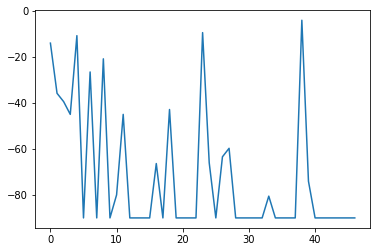

In [136]:
final_df.loc[0:46, 'angle']
plt.plot(final_df.loc[0:46, 'angle'])

final_df.loc[0:46, 'angle'].mean()

In [128]:
21/1.8 # hz

11.666666666666666

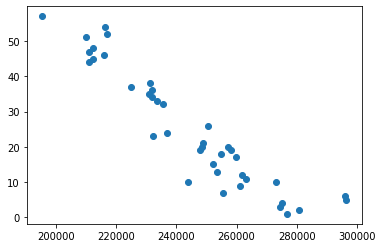

In [118]:
plt.scatter(clust.x*clust.y, clust.frame)